In this post we will work through performing the response time correction on oxygen observations following [Bittig et al. (2014)](https://doi.org/10.4319/lom.2014.12.617) on Argo data. The focus is more on accessing the proper variables within Argo than describing the actual correction. We will use [argopandas](https://github.com/ArgoCanada/argopandas) package to manage our data fetching from Argo, and use a function from [bgcArgoDMQC]((https://github.com/ArgoCanada/bgcArgoDMQC)) to do the response time correction. Other basic data manipulation and visualization will use the [pandas](https://pandas.pydata.org/), [numpy](https://numpy.org/), and [scipy](https://scipy.org/) packages, and [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/) for plotting.

In [15]:
# conda install -c conda-forge argopandas bgcArgoDMQC
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

import argopandas as argo
from bgcArgoDMQC import correct_response_time

We will use float [7900589](https://fleetmonitoring.euro-argo.eu/float/7900589), an APEX float in the North Atlantic which has the intermediate parameter `MTIME`, defined as the relative time in fractional days since the date of the profile `JULD`.

In [2]:
flt = argo.float(7900589)
# grab core and bgc files for just the most recent cycle
core = flt.prof
bgc  = flt.bio_prof
core = core[core.file == core.file.iloc[-1]]
bgc  = bgc[bgc.file == bgc.file.iloc[-1]]

In [3]:
core

,file,date,latitude,longitude,ocean,profiler_type,institution,date_update
1853971,coriolis/7900589/profiles/R7900589_043.nc,2021-11-08 12:13:44+00:00,55.682,-46.691,A,846,IF,2021-11-08 15:34:25+00:00


In [4]:
bgc

,file,date,latitude,longitude,ocean,profiler_type,institution,parameters,parameter_data_mode,date_update
179672,coriolis/7900589/profiles/BR7900589_043.nc,2021-11-08 12:13:44+00:00,55.682,-46.691,A,846,IF,MTIME PRES TEMP_DOXY C1PHASE_DOXY C2PHASE_DOXY...,RRRRRARRRARR,2021-11-08 16:02:45+00:00


In [5]:
core_df = core.levels[['PRES', 'TEMP', 'PSAL']]
bgc_df  = bgc.levels[['PRES', 'MTIME', 'DOXY']]

Reading 1 file
Reading 1 file


In [6]:
core_df

PRES    TEMP  \
file                                      N_PROF N_LEVELS                 
coriolis/7900589/profiles/R7900589_043.nc 0      0         0.43  6.7983   
                                                 1         2.30  6.7997   
                                                 2         4.42  6.8032   
                                                 3         6.01  6.8057   
                                                 4         8.07  6.8026   
...                                                         ...     ...   
                                          3      470        NaN     NaN   
                                                 471        NaN     NaN   
                                                 472        NaN     NaN   
                                                 473        NaN     NaN   
                                                 474        NaN     NaN   

                                                                PSAL  
file                                      N_PROF N_LEVELS             
coriolis/7900589/profiles/R7900589_043.nc 0      0         34.502201  
                                                 1         34.501499  
                                                 2         34.501801  
                                                 3         34.501900  
                                                 4         34.502102  
...                                                              ...  
                                          3      470             NaN  
                                                 471             NaN  
                                                 472             NaN  
                                                 473             NaN  
                                                 474             NaN  

[1900 rows x 3 columns]

In [7]:
bgc_df

PRES     MTIME  \
file                                       N_PROF N_LEVELS                   
coriolis/7900589/profiles/BR7900589_043.nc 0      0         0.43 -0.000613   
                                                  1         2.30 -0.001296   
                                                  2         4.42       NaN   
                                                  3         6.01       NaN   
                                                  4         8.07       NaN   
...                                                          ...       ...   
                                           3      470        NaN       NaN   
                                                  471        NaN       NaN   
                                                  472        NaN       NaN   
                                                  473        NaN       NaN   
                                                  474        NaN       NaN   

                                                            DOXY  
file                                       N_PROF N_LEVELS        
coriolis/7900589/profiles/BR7900589_043.nc 0      0          NaN  
                                                  1          NaN  
                                                  2          NaN  
                                                  3          NaN  
                                                  4          NaN  
...                                                          ...  
                                           3      470        NaN  
                                                  471        NaN  
                                                  472        NaN  
                                                  473        NaN  
                                                  474        NaN  

[1900 rows x 3 columns]

You will notice looking at the printout of `bgc_df` that there are a lot of NaN values. The valid `MTIME` and `DOXY` values are in the `N_PROF` dimension 2. There are a variety of reasons why there might be `N_PROF` > 1 dimensions in an Argo profile. Where that is not the subject I won't go into why, and frankly I only know the valid data is in `N_PROF` = 2 by inspecting the dataframe. The valid core data is in `N_PROF` = 0. If we simply tried to line these separate dataframes up into one, we would fail miserably since our time and oxygen data would not be aligned with our physical data. So instead, we will use the common pressure axis to interpolate onto a common axis.

In [12]:
# create a dataframe to store interpolated data in
df = pd.DataFrame()
# define a pressure axis to interpolate and a depth resolution
dP = 2.5
interp_pressure = np.arange(0, core_df['PRES'].max(), dP)
df['PRES'] = interp_pressure
# interpolate
for key, source in zip(['MTIME', 'TEMP', 'DOXY'], [bgc_df, core_df, bgc_df]):
    ix = source[key].notna() # remove nan values that will mess with interp
    f = interp1d(source['PRES'][ix], source[key][ix], bounds_error=False)
    df[key] = f(interp_pressure)

In [13]:
df

,PRES,MTIME,TEMP,DOXY
0,0.0,NaN,NaN,NaN
1,2.5,-0.001345,6.800030,265.266078
2,5.0,-0.001957,6.804258,265.227454
3,7.5,-0.002542,6.802751,265.246096
4,10.0,-0.003235,6.804123,264.956293
...,...,...,...,...
374,935.0,-0.139717,3.358495,263.701094
375,937.5,-0.140046,3.354090,263.718486
376,940.0,-0.140375,3.351910,263.735879
377,942.5,-0.140704,3.351850,263.753272


Now we are almost ready to perform the time response correction, except that *we don't know what the time response of this optode is*. Without a reference data set like in [Bittig et al. (2014)](https://doi.org/10.4319/lom.2014.12.617) or consecutive up- and down-casts as in [Gordon et al. (2020)](https://doi.org/10.5194/bg-17-4119-2020), knowing the response time is not possible. For the purposes of demonstration we will choose a boundary layer thickness (an equivalent parameter, but independent of temperature unlike response time) of 120 micrometers (equivalent to a response time of 67.2 seconds at 20 degrees C).

In [20]:
Il = 120
df['DOXY_ADJUSTED'] = correct_response_time(df['MTIME'], df['DOXY'], df['TEMP'], Il)
df['DOXY_DELTA'] = df.DOXY - df.DOXY_ADJUSTED # change in oxygen

Finally, we'll plot the profiles to see the end result of the correction.

C:\Users\GordonC\AppData\Local\Temp\1/ipykernel_25976/3416147837.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_melt = df.melt(id_vars=['PRES', 'MTIME', 'TEMP', 'DOXY_DELTA'], var_name='DOXY_STATUS', value_name='DOXY')


(250.0, 0.0)

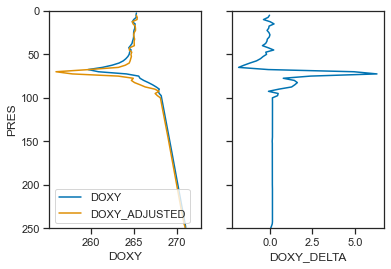

In [26]:
# melt the dataframe so that we can use hue keyword when plotting
df_melt = df.melt(id_vars=['PRES', 'MTIME', 'TEMP', 'DOXY_DELTA'], var_name='DOXY_STATUS', value_name='DOXY')

fig, axes = plt.subplots(1, 2, sharey=True)
sns.lineplot(x='DOXY', y='PRES', hue='DOXY_STATUS', data=df_melt, sort=False, ax=axes[0])
sns.lineplot(x='DOXY_DELTA', y='PRES', data=df, sort=False, ax=axes[1])
axes[0].legend(loc=3)
axes[0].set_ylim((250, 0))


Some observations based on the above:

- It is important to recall that this is an *ascending* profile.
- The first thing your eye was likely drawn to is the large change 70m depth. I would wager that this single point is probably too dramatic, but also could be real as the gradient is strong there and oxygen would be favouring the higher side. This point makes me uncomfortable without reference data, but I can't say for sure that it is wrong. 
- From 250-100m, oxygen is relatively linear. In this section of the profile, we see a slighly lower `DOXY_ADJUSTED` than the original `DOXY`. Since oxygen is *decreasing* as the float *ascends*, the float remembers the higher concentration from the deeper depth, and therefore slightly overestimates the true oxygen concentration. 
- At points where there are "notches" in the original profile, those "notches" are amplified in the corrected on.

Thinking more generally about the wider Argo program, there are a few key questions: 

- How would you include this adjusted data in the B-file? Would it go in the `DOXY_ADJUSTED` field, which currently is used for gain adjustment ([Johnson et al. (2015)](https://doi.org/10.1175/JTECH-D-15-0101.1)), or would it merit a different field?
- Assuming there is no reliable way to determine boundary layer thickness (time constant), should Argo correct using a generic one since the adjusted data will be "more correct" than the original, even if it is not perfect?
- Given a lack of reference data, how would you flag the above adjusted profile? Are there any points you don't believe that should be flagged as bad?